# Variational encoder model

## import lib


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import cudnn

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm


## ML pipeline

### Step 0. Model Hyperparameters

In [60]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 300
x_dim = 19
hidden_dim = 64
output_dim = 19

lr = 1.0e-3
epochs = 125

training_seed = 21


### Step 1. Load Dataset

get data from file

In [61]:
num_seeds = 30
seed = 0
# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-fullstate-rand-{i}.npz")    
    data_no_joint_pos[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    data_no_joint_vel[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    data_no_action[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    data_no_imu[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    data_no_fc[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")

In [62]:
all_state_dim = 64
state_dim = 64
action_dim = 19

train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_no_joint_pos[j]["state"].reshape(data_no_joint_pos[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_no_joint_pos[j]["action_lowpass"].reshape(data_no_joint_pos[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

Converge to TensorDataset

In [63]:
state_index = torch.arange(0, 19)
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y)
test_dataset = TensorDataset(test_x[:,state_index], test_y)

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TRAIN : X , Y shape :  torch.Size([21000, 19]) torch.Size([21000, 19])
TEST : X , Y shape :  torch.Size([9000, 19]) torch.Size([9000, 19])


Explore some data

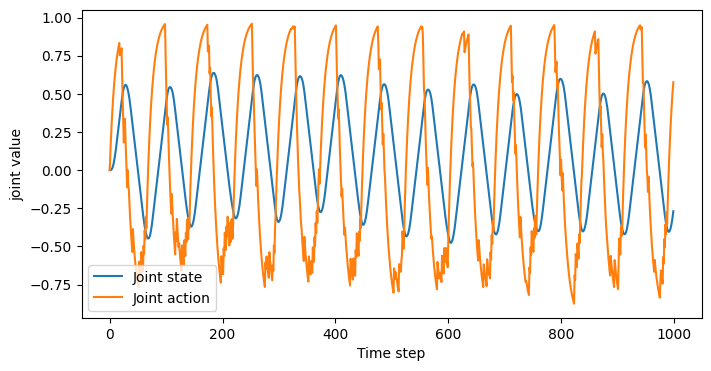

In [64]:
plt.figure(figsize=(8, 4))
plt.plot(train_x[:, state_index].cpu().numpy()[10000:11000, 6], label='Joint state')
plt.plot(train_y.cpu().numpy()[10000:11000, 6], label='Joint action')
plt.xlabel('Time step')
plt.ylabel('joint value')
plt.legend()

### Step 2. Define Model

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder
"""
class Predictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.FC_mean  = nn.Linear(hidden_dim, output_dim)
        self.FC_var   = nn.Linear (hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        # self.LeakyReLU = nn.ReLU()
        self.softplus = nn.Softplus()
        
        self.training = True
        
    def reparameterization(self , mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
    
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        mean     = self.FC_mean(h_)         # encoder produces mean and log of variance 
        log_var  = self.FC_var(h_)          # (i.e., parateters of simple tractable normal distribution "q"
        # log_var  = self.softplus(log_var)  # clamp log_var to avoid numerical issues
        
        z = self.reparameterization(mean, torch.exp(log_var))  # reparameterization trick
        # z is sampling from the distribution z = mean + var * epsilon
        return z,mean, log_var

In [66]:
print(state_dim)

19


In [67]:
model = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
# model = NN(input_dim=state_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)

### Step 3. Define Loss function
- using MSE loss

$$
\mathcal{L}(z,\hat{z}) = \| z^2 - \hat{z}^2 \|^2
$$

In [68]:
MSEloss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = MSEloss(x_hat, x)  # Using MSE loss instead of binary cross entropy
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


### Step 4. Training network

In [ ]:
# ----- Training Loop -----
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)    # dim = [batch_size, state_dim]
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        pred, mean , log_var = model(x_batch)
        loss = MSEloss(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(train_dataset)
    train_losses.append(avg_loss)

    # ----- Evaluate -----
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred, mean , log_var = model(x_batch)
            total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

    avg_test_loss = total_test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/125 | Train Loss: 2.402126 | Test Loss: 1.828588
Epoch 2/125 | Train Loss: 1.155348 | Test Loss: 1.587856
Epoch 3/125 | Train Loss: 1.071116 | Test Loss: 1.509457
Epoch 4/125 | Train Loss: 1.052107 | Test Loss: 1.472793
Epoch 5/125 | Train Loss: 1.044211 | Test Loss: 1.455896
Epoch 6/125 | Train Loss: 1.036193 | Test Loss: 1.446906
Epoch 7/125 | Train Loss: 1.031713 | Test Loss: 1.440181
Epoch 8/125 | Train Loss: 1.035421 | Test Loss: 1.425700
Epoch 9/125 | Train Loss: 1.031811 | Test Loss: 1.442609
Epoch 10/125 | Train Loss: 1.028833 | Test Loss: 1.440920
Epoch 11/125 | Train Loss: 1.029247 | Test Loss: 1.436340
Epoch 12/125 | Train Loss: 1.028214 | Test Loss: 1.445273
Epoch 13/125 | Train Loss: 1.029018 | Test Loss: 1.454412
Epoch 14/125 | Train Loss: 1.029340 | Test Loss: 1.461140
Epoch 15/125 | Train Loss: 1.026582 | Test Loss: 1.452655
Epoch 16/125 | Train Loss: 1.024794 | Test Loss: 1.487191
Epoch 17/125 | Train Loss: 1.021499 | Test Loss: 1.474634
Epoch 18/125 | Train Lo

Text(0, 0.5, 'Loss')

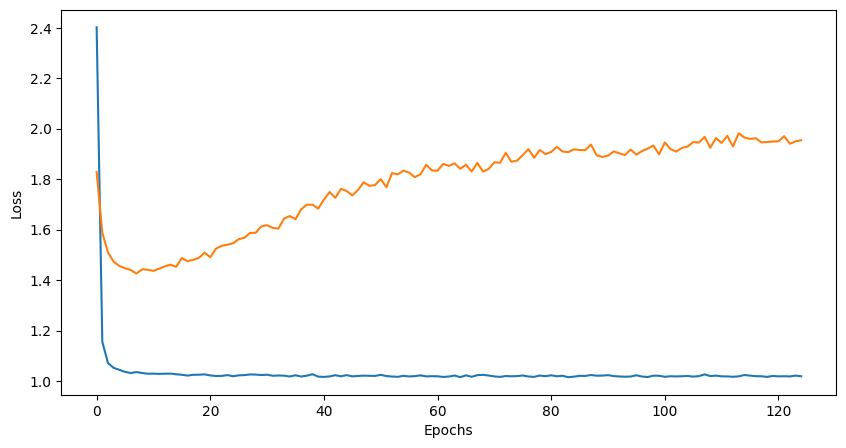

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [78]:
# ----- Evaluate -----
model.eval()
total_test_loss = 0.0
preds_list, targets_list = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        pred, mean , log_var = model(x_batch)
        total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

        preds_list.append(pred.cpu().numpy())
        targets_list.append(y_batch.cpu().numpy())

avg_test_loss = total_test_loss / len(test_dataset)

# Convert all predictions and targets
preds_all = np.vstack(preds_list)
targets_all = np.vstack(targets_list)

# ---- Metrics ----
mse = np.mean((preds_all - targets_all)**2, axis=0)           # per output
rmse = np.sqrt(mse)
mae = np.mean(np.abs(preds_all - targets_all), axis=0)
ss_res = np.sum((targets_all - preds_all) ** 2, axis=0)
ss_tot = np.sum((targets_all - np.mean(targets_all, axis=0)) ** 2, axis=0)
r2 = 1 - ss_res / ss_tot

print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Test Loss (MSE): {avg_test_loss:.6f}")
print(f"  MAE per output:  {mae}")
print(f"  RMSE per output: {rmse}")
print(f"  R2 per output:   {r2}")

Epoch 125/125 | Train Loss: 1.018834 | Test Loss (MSE): 1.960985
  MAE per output:  [1.2057189  1.3072768  1.2262645  1.0660143  1.2954443  1.2559797
 1.1572003  0.9516121  1.133529   0.8701544  0.8801466  1.1391541
 1.2914767  1.2766409  1.2978512  1.123657   0.9793843  0.81200296
 1.1528639 ]
  RMSE per output: [1.4888655 1.593806  1.5160178 1.3238895 1.5752122 1.5327249 1.4200041
 1.1794001 1.3900354 1.0903549 1.1003894 1.4096584 1.5780044 1.5549024
 1.5773584 1.3891472 1.2210269 1.0191166 1.4278145]
  R2 per output:   [ -2.6721058  -3.1779633  -2.656221   -5.118781   -4.438364   -4.817047
  -5.8953114 -24.010233   -7.424034  -29.44538   -20.01794    -4.6555734
  -4.298172   -4.3471785  -6.0225787  -3.0869522  -3.3272843 -19.336357
  -2.5094283]


In [72]:
test_x[:,state_index].shape


torch.Size([9000, 19])

In [73]:
idx = 4
print(model(test_x[idx , state_index])[0])
print(torch.normal( model(test_x[idx , state_index])[0], torch.exp(model(test_x[idx , state_index])[1])))
print(test_y[idx , state_index])

tensor([ 1.1663,  0.3893,  0.8378, -1.9613,  0.6463,  0.4851,  2.2782, -0.0892,
        -0.8101,  1.1390, -1.0563,  0.0790, -1.0335, -3.0904, -1.0246, -0.2734,
        -0.5903, -0.8440,  0.1889], device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 3.4186,  0.4374,  0.4672, -0.7039, -2.1775,  0.5609,  4.2196, -0.8463,
        -1.8332, -1.2053, -1.0888,  1.7208,  1.3467, -1.6634, -1.1280,  0.9418,
         0.1594, -3.3922,  3.4014], device='cuda:0', grad_fn=<NormalBackward3>)
tensor([ 0.3439,  0.2428,  0.3439, -0.3416, -0.2206,  0.3439,  0.3117, -0.1444,
        -0.3436, -0.3439, -0.1670,  0.1925, -0.1582, -0.3439, -0.3439, -0.1447,
         0.1695,  0.3404, -0.0277], device='cuda:0')


In [74]:
print(torch.exp(model(test_x[idx , state_index])[1]))

tensor([2.0549, 2.3045, 2.2767, 0.4310, 0.3917, 1.9777, 2.3686, 0.7001, 0.5035,
        0.5799, 0.8703, 2.1100, 2.3267, 0.4637, 0.4409, 0.4749, 0.6660, 1.8209,
        0.5313], device='cuda:0', grad_fn=<ExpBackward0>)


In [75]:
print((model(test_x[idx , state_index])[0]))

tensor([-0.7859,  0.8749,  1.4170, -1.4503,  0.5670,  0.8136,  0.7816, -0.4796,
        -1.3284, -1.3590, -0.9524,  0.6684,  1.0765,  1.0919,  1.6703, -1.5142,
        -2.7216,  0.0273,  0.7629], device='cuda:0', grad_fn=<AddBackward0>)


In [76]:
print((model(test_x[idx , state_index])[1]))
print((test_y[idx , state_index]))

tensor([ 0.7202,  0.8349,  0.8227, -0.8417, -0.9374,  0.6819,  0.8623, -0.3565,
        -0.6861, -0.5449, -0.1389,  0.7467,  0.8444, -0.7686, -0.8189, -0.7447,
        -0.4065,  0.5993, -0.6325], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([ 0.3439,  0.2428,  0.3439, -0.3416, -0.2206,  0.3439,  0.3117, -0.1444,
        -0.3436, -0.3439, -0.1670,  0.1925, -0.1582, -0.3439, -0.3439, -0.1447,
         0.1695,  0.3404, -0.0277], device='cuda:0')


## Testing Section